In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# **Import data from google drive**

d_{networkname}_ret_s_fully = the spatial distance data from each layer

target = labels for each tiral, (1:right image is prefered, 0:left image is prefered)

In [ ]:
d_vgg_ret_s=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_fully.npy',allow_pickle=True)
target=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_fully.npy')

Extract the first layer spatial data from dataset

In [ ]:
d_vgg_ret_s=d_vgg_ret_s[:,0]

Image plotting:

The spatial distance data from first layer

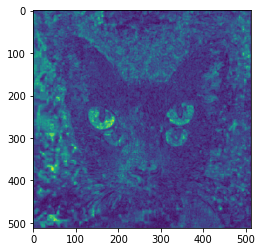

In [ ]:
plt.imshow(d_vgg_ret_s[0].data.cpu().reshape(512,512))

Transform the spatial distance data fron tensor into numpy as 512*512 shape

In [ ]:
d_vgg_ret_s_clean=[]
for d in d_vgg_ret_s:
  d_vgg_ret_s_clean.append(d.data.cpu().numpy().reshape(512,512))
d_vgg_ret_s_clean=np.array(d_vgg_ret_s_clean)
target=np.array(target)

In [ ]:
target[:100]

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int32)

Some sameples about the data we are going to use in this experiment, the top two images are the inputs for LPIPS, and the butten image represent the percepture similarity image (the spatial distance data) from the first layer of LPIPS

In [ ]:
left_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/left_img_data_fully.npy')
right_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/right_img_data_fully.npy')

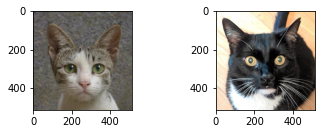

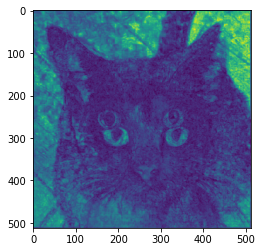

In [ ]:
img_index=1000 # the first pair of image trial
plt.subplot(2,2,1)
plt.imshow(left_img[img_index])
plt.subplot(2,2,2)
plt.imshow(right_img[img_index])
plt.show()
plt.imshow(d_vgg_ret_s_clean[img_index])

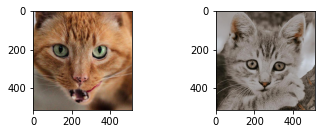

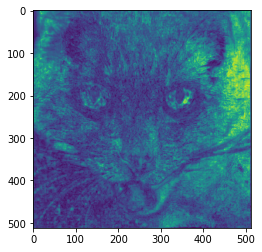

In [ ]:
img_index=1 # the first pair of image trial
plt.subplot(2,2,1)
plt.imshow(left_img[img_index])
plt.subplot(2,2,2)
plt.imshow(right_img[img_index])
plt.show()
plt.imshow(d_vgg_ret_s_clean[img_index])

Here we check the quantities of each classes.

We can see Eddy's behavior data is slightly class imbalance.

In [ ]:
def check_class_numbers(target):
  return np.count_nonzero(target ==1), np.count_nonzero(target ==0)

In [ ]:
check_class_numbers(target)

(626, 599)

To construct the CNN model:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(512,512,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,kernel_size=(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
#now flaten the layer and a1dd hiden layers
model.add(Flatten())
# First hiden layer:
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
# Third hiden layer:
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))
# Fourth hiden layer:
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
# Output layer:
model.add(Dense(2,activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

Import and pre-processing the testing and validation data, the label is one-hot encoded. For the tesing and validataion data, I use the fisrt random sampled cat face expreiment pair image with the same oberser's behavior data.

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# data_train, data_test, y_train, y_test = train_test_split(d_vgg_s_clean, y_onehot, random_state = 20211001, test_size = 0.2)
data_train=d_vgg_ret_s_clean
y_train=y_onehot
data_test=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_s_300.npy',allow_pickle=True)
y_test=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_random_300.npy',allow_pickle=True)
encoder = OneHotEncoder(sparse=False)
# transform data
y_test=np.asarray(y_test).astype('float32').reshape((-1,1))
y_test = encoder.fit_transform(y_test)
print(y_test[:10])

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
#one-hot encoding for targets
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# transform data
y_2d=np.asarray(target).astype('float32').reshape((-1,1))
y_onehot = encoder.fit_transform(y_2d)
print(target[:10])
print(y_onehot[:10])


[1 0 1 1 1 0 1 1 1 1]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Extract the first layer spatial data from dataset

In [ ]:
data_test=data_test[:,0]
temp=[]
for d in data_test:
  temp.append(d[0].data.cpu().numpy().reshape(512,512))
data_test=np.array(temp)
del temp

Split the test dataset into test and val dataset

In [ ]:
data_test, y_test, data_val, y_val=data_test[:200],y_test[:200],data_test[200:300],y_test[200:300]

Check the class imbalance of testing and validation data

In [ ]:
print(check_class_numbers(np.array([np.argmax(y) for y in y_test])))
print(check_class_numbers(np.array([np.argmax(y) for y in y_val])))

(105, 95)
(57, 43)


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully_first_layer.best.hdf5',
                             verbose = 1,
                             save_best_only = True)

Start training

In [ ]:
model.compile(loss = 'BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
nn = model.fit(data_train,y_train,
                   batch_size = 64,
                   epochs = 20,
                   validation_data=(data_test,y_test),
                   callbacks = [checkpoint],
                   shuffle=True)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.5127
Epoch 00001: val_loss improved from inf to 0.70224, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully_first_layer.best.hdf5
20/20 [==============================] - 33s 1s/step - loss: 0.9800 - accuracy: 0.5127 - val_loss: 0.7022 - val_accuracy: 0.4750
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7085 - accuracy: 0.4910
Epoch 00002: val_loss improved from 0.70224 to 0.69186, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully_first_layer.best.hdf5
20/20 [==============================] - 7s 367ms/step - loss: 0.7089 - accuracy: 0.4882 - val_loss: 0.6919 - val_accuracy: 0.5650
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7038 - accuracy: 0.5090
Epoch 00003: val_loss improved from 0.69186 to 0.69005, saving model to /content/drive/MyD

In [ ]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

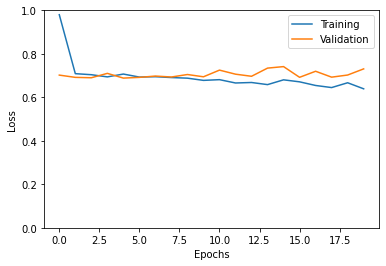

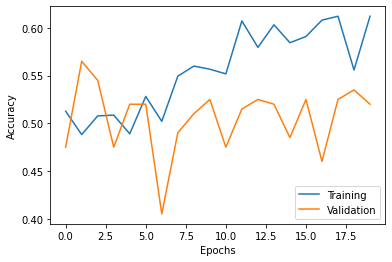

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def nn_hisotry(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylim((0, 1))

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

nn_hisotry(nn)

In [ ]:
import pandas as pd
table={'title':['Accurancy','Val_accurancy'],'value':[max(nn_fs.history['accuracy']),max(nn_fs.history['val_accuracy'])]}
pd.DataFrame(table)

,title,value
0,Accurancy,0.612245
1,Val_accurancy,0.565000


In [ ]:
from keras.models import load_model
model = load_model(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG16_S_fully_first_layer.best.hdf5')
model.evaluate(data_val,y_val)

4/4 [==============================] - 1s 62ms/step - loss: 0.7241 - accuracy: 0.5000


[0.7241355180740356, 0.5]

In [ ]:
predicted_classes = np.argmax(model.predict(data_val),axis=1)

# see which we predicted correctly and which not
y_val_clean=[np.argmax(i) for i in y_val]
correct_indices = np.nonzero(predicted_classes == y_val_clean)[0]
incorrect_indices = np.nonzero(predicted_classes != y_val_clean)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print(f'prediction:{predicted_classes}')
print(f'target:{np.array(y_val_clean)}')


50  classified correctly
50  classified incorrectly
prediction:[1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0]
target:[1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0
 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1
 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1]
